# House Prices - Advanced Regression Techniques
### Mitko Stoychev
*Titanic Top 5% with ensemble modeling* - *For this first version best model score is 0.0,79665*

07/04/2024

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import skew
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
print(train_data.shape)
print(test_data.shape)
train_data.head(7)

(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000


There are 81 columns, where 79 are feature columns.

Using these features, the model has to predict the house sale price indicated by the label column named "SalePrice".

I´ll drop the "Id" column because it´s not a feature column therefore it´s not necesarry for the model.

Let´s start inspecting the types of feature columns.

In [3]:
# Remove the "Id" columns
id_train_data = train_data["Id"]
id_test_data = test_data["Id"]

train_data = train_data.drop(["Id"], axis=1)
test_data = test_data.drop(["Id"], axis=1)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## House Price Distribution

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
median:  163000.0


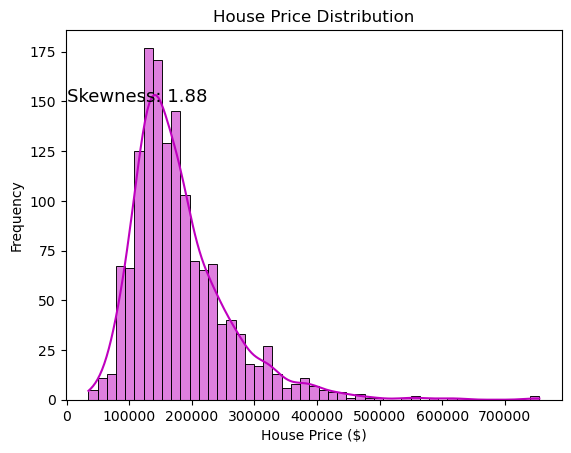

In [4]:
# Exploring SALE PRICE DISTRIBUTION

# Print SalePrice describe statistics
print(train_data['SalePrice'].describe())
print("median: ", train_data['SalePrice'].median())

# Plot a histrogram of SalePrice
sns.histplot(train_data["SalePrice"], color="m", kde=True)
plt.title("House Price Distribution")
plt.xlabel("House Price ($)")
plt.ylabel("Frequency")
plt.text(200, 150, "Skewness: %.2f" % train_data["SalePrice"].skew(), fontsize=13)
plt.show()

## Numerical data distribution
We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [5]:
train_data.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [6]:
#select only the numeric data
df_num = train_data.select_dtypes(include=['int64', 'float64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Now let us plot the distribution for all the numerical features.

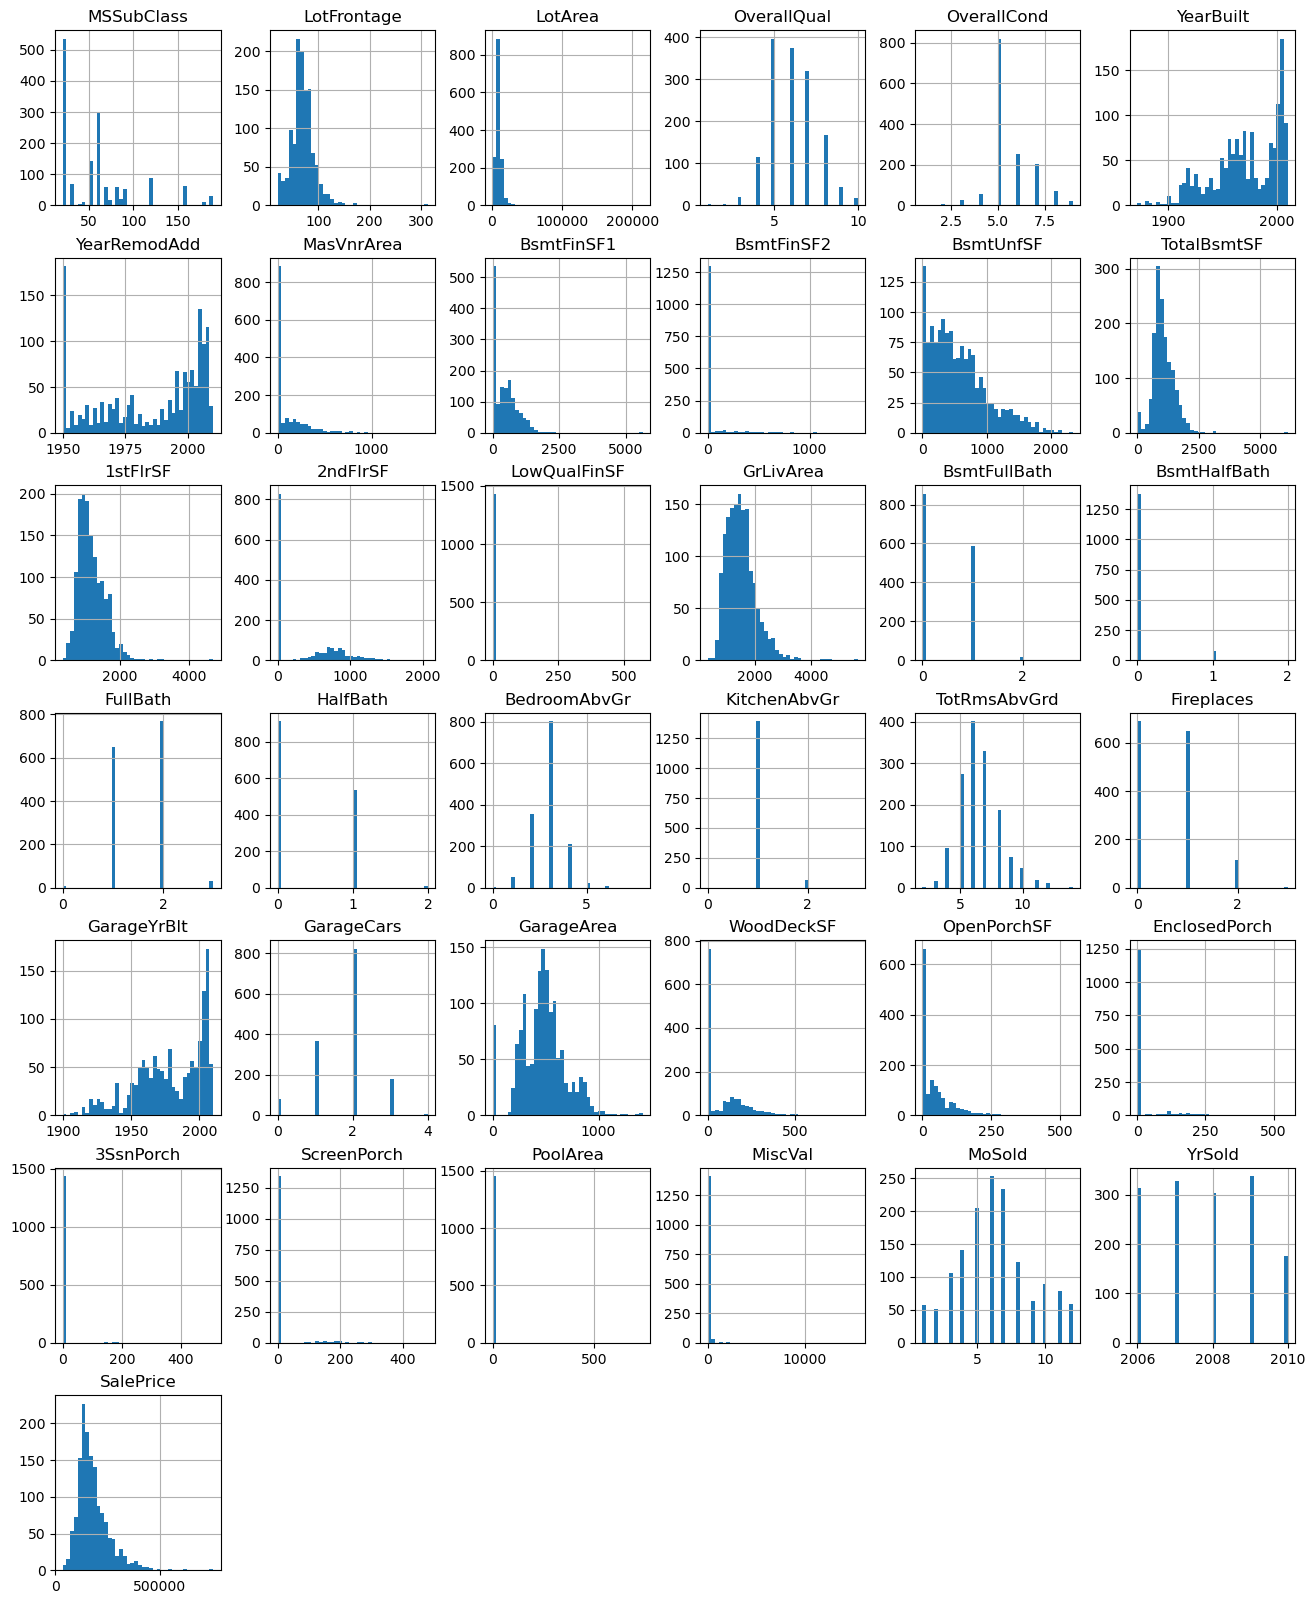

In [7]:
df_num.hist(figsize=(16,20), bins=40)
plt.show()

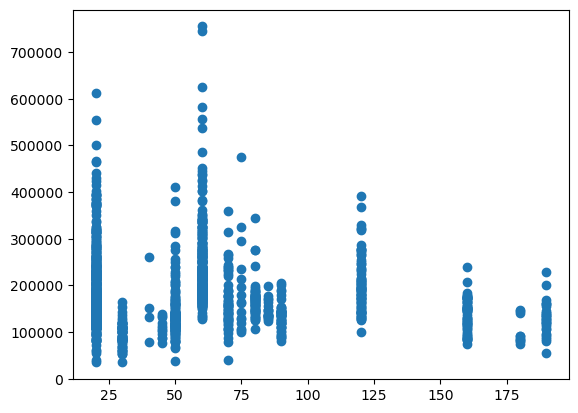

In [8]:
# MSSubClass → The building class → actually is a categorical data but already transformed
plt.scatter(x="MSSubClass", y="SalePrice", data=train_data)
plt.show()

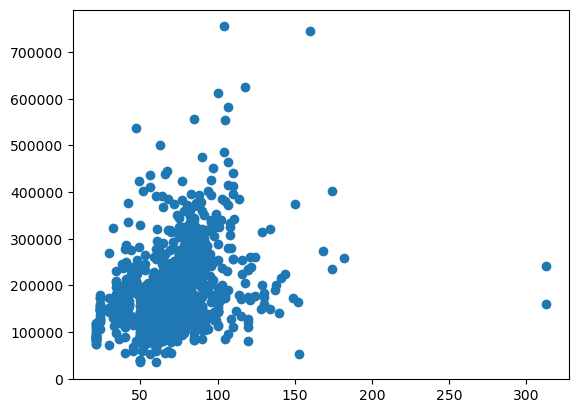

In [9]:
# LotFrontage → Linear feet of street connected to property 
plt.scatter(x="LotFrontage", y="SalePrice", data=train_data)
plt.show()

We can clearly see a 2 outliers. I am going to create a list with my outlier detection, then I´ll use the Tukeys method anyways.

In [10]:
train_data.query("LotFrontage > 300")
# Drop 934, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


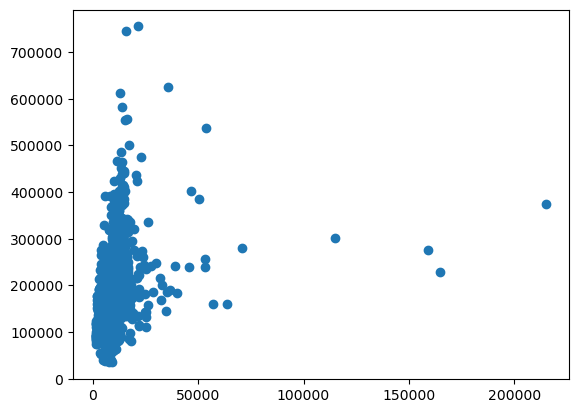

In [11]:
# LotArea → Lot size in square feet
plt.scatter(x="LotArea", y="SalePrice", data=train_data)
plt.show()

In [12]:
train_data.query("LotArea > 56000")

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,CulDSac,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,Corner,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
451,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
706,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1396,20,RL,NaN,57200,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,160000


In [13]:
# Drop 934, 1298, 249, 313, 335, 706
stats.zscore(train_data["LotArea"]).sort_values().tail(10)

384      4.268474
457      4.280500
769      4.308262
1396     4.678682
1298     5.348867
451      6.037793
706     10.486449
249     14.881285
335     15.448542
313     20.518273
Name: LotArea, dtype: float64

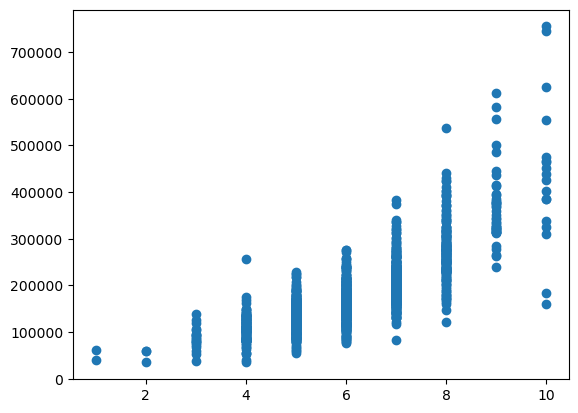

In [14]:
# OverallQual → Rates the overall material and finish of the house (ordinal data, aldeady encoded)
plt.scatter(x="OverallQual", y="SalePrice", data=train_data)
plt.show()

In [15]:
train_data.query("OverallQual == 10").sort_values("SalePrice")
# Drop →  249, 313, 335, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1442,60,FV,85.0,11003,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,310000
583,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
994,20,RL,96.0,12456,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,337500
825,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,New,Partial,385000
224,20,RL,103.0,13472,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,386250
515,20,RL,94.0,12220,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2009,New,Partial,402861
389,60,RL,96.0,12474,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2008,New,Partial,426000
58,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780


In [16]:
train_data.query("OverallQual == 8").sort_values("SalePrice")
# Drop →  249, 313, 335, 523, 691, 706, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1349,70,RM,50.0,5250,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,122000
1324,20,RL,75.0,9986,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2007,New,Partial,147000
458,70,RM,NaN,5100,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,161000
1211,50,RL,152.0,12134,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,164000
991,70,RM,121.0,17671,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,11,2009,WD,Normal,168000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,20,RL,49.0,20896,Pave,NaN,IR2,Lvl,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,1,2006,New,Partial,423000
1142,60,RL,77.0,9965,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2007,New,Partial,424870
496,20,RL,NaN,12692,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,430000
473,20,RL,110.0,14977,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2007,New,Partial,440000


In [17]:
train_data.query("OverallQual == 4").sort_values("SalePrice")
# Drop →  249, 313, 335, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
495,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
30,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,40000
1337,30,RM,153.0,4118,Pave,Grvl,IR1,Bnk,AllPub,Corner,...,0,NaN,NaN,NaN,0,3,2006,WD,Normal,52500
705,190,RM,70.0,5600,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,Othr,3500,7,2010,WD,Normal,55000
1325,30,RM,40.0,3636,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,1,2008,WD,Normal,55000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,20,RL,NaN,9991,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,GdWo,NaN,0,6,2009,WD,Normal,150000
1262,50,RL,NaN,11250,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2009,WD,Normal,161500
1190,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1020,20,RL,60.0,7024,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,176000


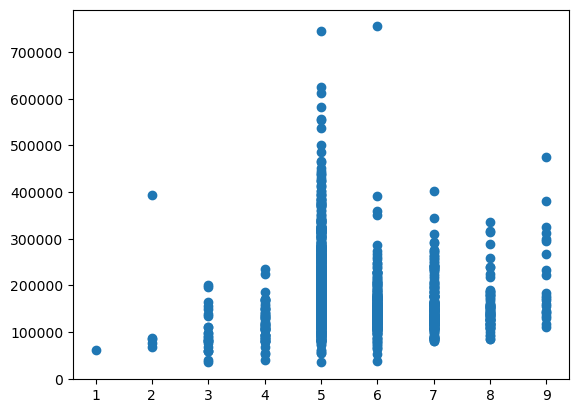

In [18]:
# OverallCond → Rates the overall condition of the house (ordinal data, aldeady encoded)
plt.scatter(x="OverallCond", y="SalePrice", data=train_data)
plt.show()

In [19]:
train_data.query("OverallCond == 2 & SalePrice > 300000")
# == 2 → 378
# == 5 → 1182
# == 6 → 691
# Drop →  249, 313, 335, 378, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
378,20,RL,88.0,11394,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,6,2010,New,Partial,394432


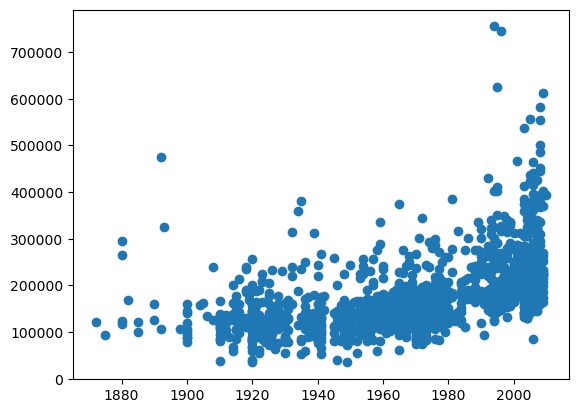

In [20]:
# YearBuilt → Original construction date
plt.scatter(x="YearBuilt", y="SalePrice", data=train_data)
plt.show()

In [21]:
train_data.query("YearBuilt < 1900 & SalePrice > 400000")
# Drop →  185, 249, 313, 335, 378, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


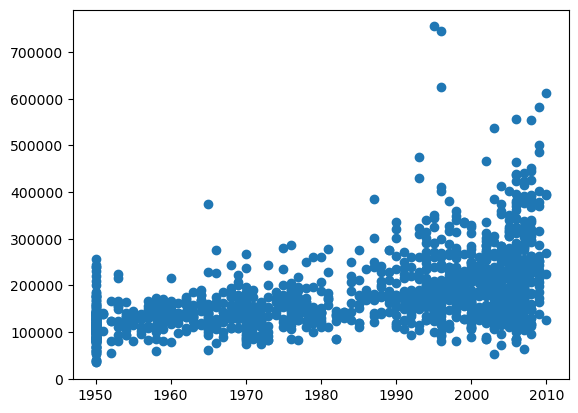

In [22]:
# YearRemodAdd → Remodel date (same as construction date if no remodeling or additions)
plt.scatter(x="YearRemodAdd", y="SalePrice", data=train_data)
plt.show()

In [23]:
train_data.query("YearRemodAdd < 1970 & SalePrice > 350000")
# Drop →  185, 249, 313, 335, 378, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000


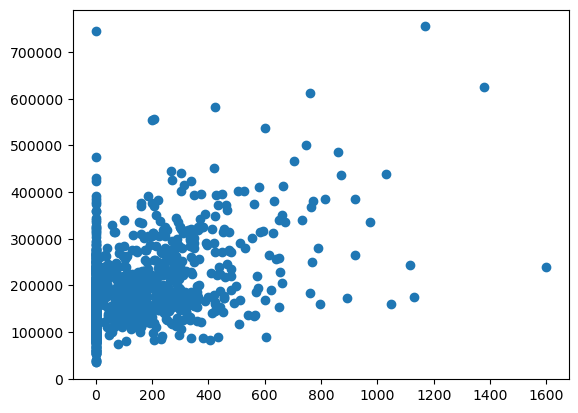

In [24]:
# MasVnrArea: Masonry veneer area in square feet
plt.scatter(x="MasVnrArea", y="SalePrice", data=train_data)
plt.show()

In [25]:
train_data.query("MasVnrArea > 1500")
# Drop →  185, 249, 297, 313, 335, 378, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
297,60,FV,66.0,7399,Pave,Pave,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,239000


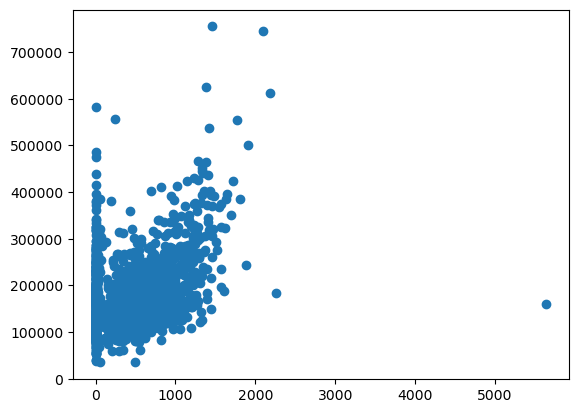

In [26]:
# BsmtFinSF1: Type 1 finished square feet
plt.scatter(x="BsmtFinSF1", y="SalePrice", data=train_data)
plt.show()

In [27]:
train_data.query("BsmtFinSF1 > 4000")
# Drop →  185, 249, 297, 313, 335, 378, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


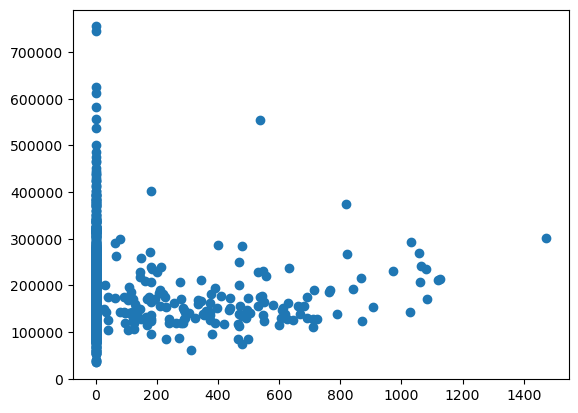

In [28]:
# BsmtFinSF2: Rating of basement finished area (if multiple types)
plt.scatter(x="BsmtFinSF2", y="SalePrice", data=train_data)
plt.show()

In [29]:
train_data.query("SalePrice > 500000 & BsmtFinSF2 >400")
# Drop →  185, 249, 297, 313, 335, 378, 440, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
440,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000


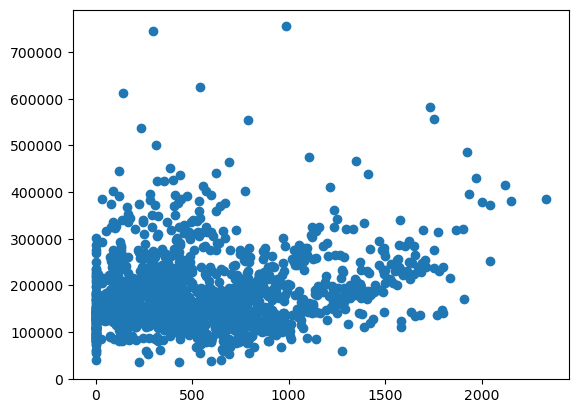

In [30]:
# BsmtUnfSF: Unfinished square feet of basement area
plt.scatter(x="BsmtUnfSF", y="SalePrice", data=train_data)
plt.show()

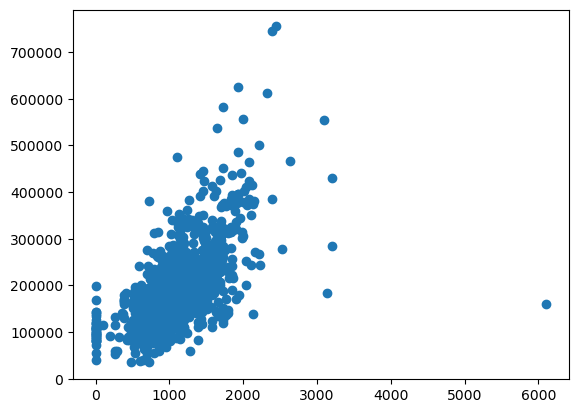

In [31]:
# TotalBsmtSF: Total square feet of basement area
plt.scatter(x="TotalBsmtSF", y="SalePrice", data=train_data)
plt.show()

In [32]:
train_data.query("TotalBsmtSF > 6000")
# Drop →  185, 249, 297, 313, 335, 378, 440, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


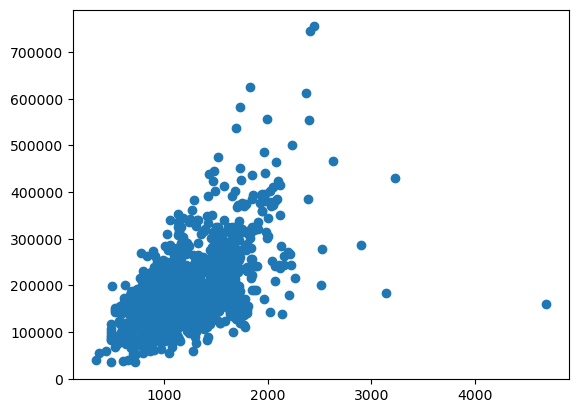

In [33]:
# 1stFlrSF: First Floor square feet
plt.scatter(x="1stFlrSF", y="SalePrice", data=train_data)
plt.show()

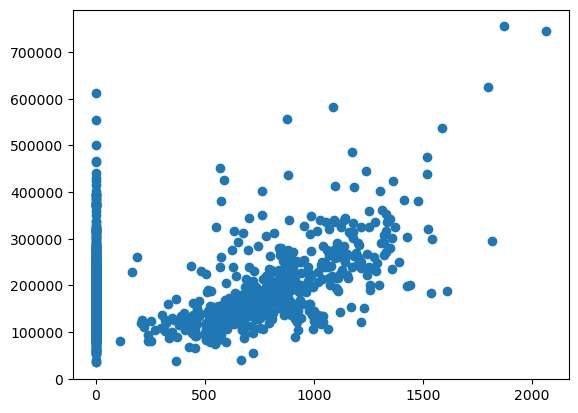

In [34]:
# 2ndFlrSF: Second Floor square feet
plt.scatter(x="2ndFlrSF", y="SalePrice", data=train_data)
plt.show()

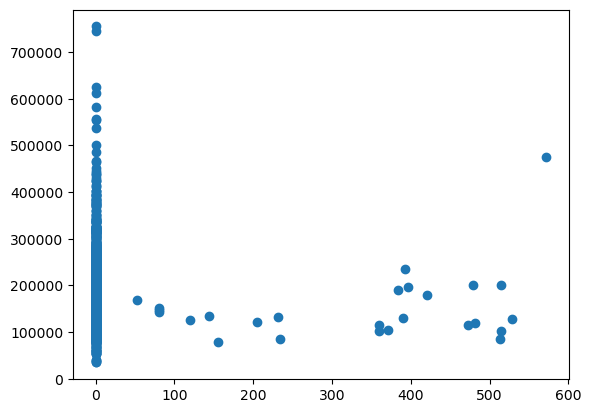

In [35]:
# LowQualFinSF: Low quality finished square feet (all floors)
plt.scatter(x="LowQualFinSF", y="SalePrice", data=train_data)
plt.show()

In [36]:
train_data.query("LowQualFinSF > 550")
# Drop →  185, 249, 297, 313, 335, 378, 440, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


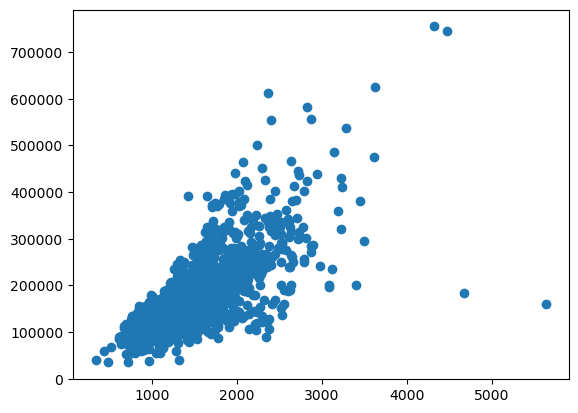

In [37]:
# GrLivArea: Above grade (ground) living area square feet
plt.scatter(x="GrLivArea", y="SalePrice", data=train_data)
plt.show()

In [38]:
train_data.query("GrLivArea > 4500")
# Drop →  185, 249, 297, 313, 335, 378, 440, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


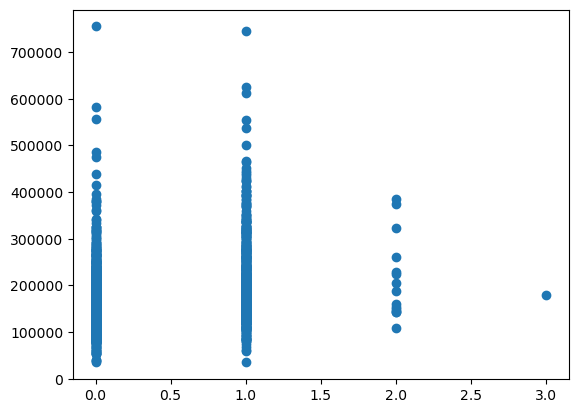

In [39]:
# BsmtFullBath:  Basement full bathrooms
plt.scatter(x="BsmtFullBath", y="SalePrice", data=train_data)
plt.show()

In [40]:
train_data.query("BsmtFullBath == 3")
# Drop →  185, 249, 297, 313, 335, 378, 440, 457, 523, 691, 706, 738, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
738,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000


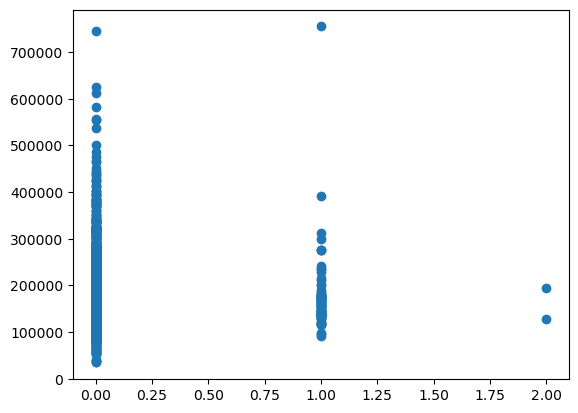

In [41]:
# BsmtHalfBath:  Basement half bathrooms
plt.scatter(x="BsmtHalfBath", y="SalePrice", data=train_data)
plt.show()

In [42]:
train_data.query("BsmtHalfBath == 2")
# Drop →  185, 249, 297, 313, 335, 378, 440, 457, 523, 597, 691, 706, 738, 769, 934, 954, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
597,120,RL,53.0,3922,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2007,New,Partial,194201
954,90,RL,35.0,9400,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,10,2006,WD,AdjLand,127500


In [43]:
stats.zscore(train_data["BsmtHalfBath"]).unique()

array([-0.24106104,  3.94880935,  8.13867973])

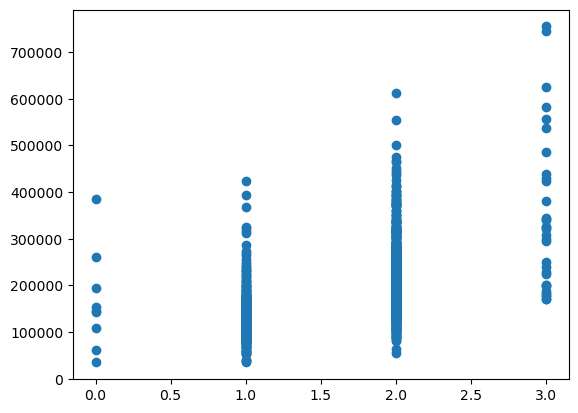

In [44]:
# FullBath: Full bathrooms above grade
plt.scatter(x="FullBath", y="SalePrice", data=train_data)
plt.show()

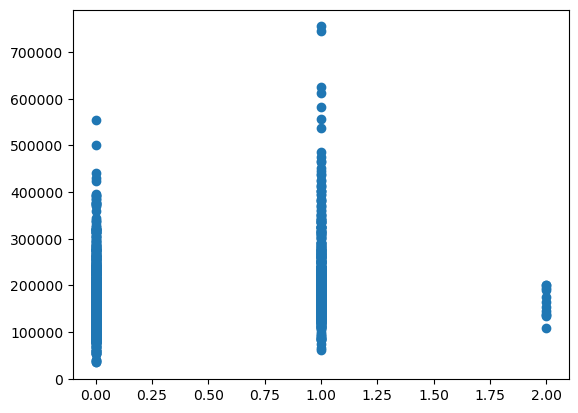

In [45]:
# HalfBath: Half baths above grade
plt.scatter(x="HalfBath", y="SalePrice", data=train_data)
plt.show()

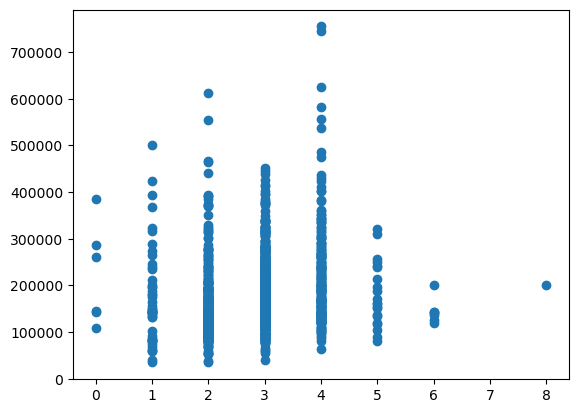

In [46]:
# BedroomAbvGr → Bedrooms above ground
plt.scatter(x="BedroomAbvGr", y="SalePrice", data=train_data)
plt.show()

In [47]:
train_data.query("BedroomAbvGr == 8")
# Drop →  185, 249, 297, 313, 335, 378, 440, 457, 523, 597, 635, 691, 706, 738, 769, 934, 954, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


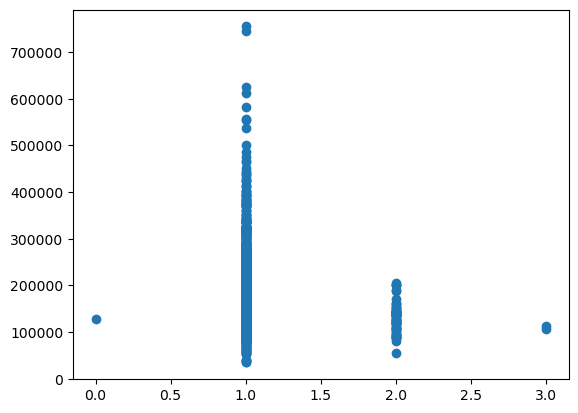

In [48]:
# KitchenAbvGr → Kitchen above ground
plt.scatter(x="KitchenAbvGr", y="SalePrice", data=train_data)
plt.show()

In [49]:
train_data.query("KitchenAbvGr == 3")
# Drop → 48, 185, 249, 297, 313, 335, 378, 440, 457, 523, 597, 635, 691, 706, 738, 769, 809, 934, 954, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
48,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
809,75,RM,90.0,8100,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,MnPrv,NaN,0,11,2009,WD,Normal,106000


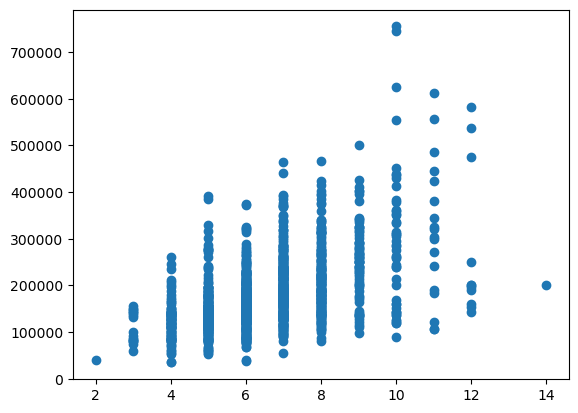

In [50]:
# TotRmsAbvGrd → Total rooms above ground
plt.scatter(x="TotRmsAbvGrd", y="SalePrice", data=train_data)
plt.show()

In [51]:
train_data.query("TotRmsAbvGrd == 14")
# Drop → 48, 185, 249, 297, 313, 335, 378, 440, 457, 523, 597, 635, 691, 706, 738, 769, 809, 934, 954, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


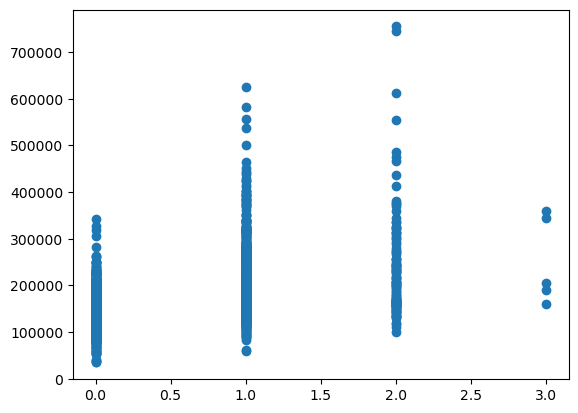

In [52]:
# Fireplaces → Number of fireplaces
plt.scatter(x="Fireplaces", y="SalePrice", data=train_data)
plt.show()

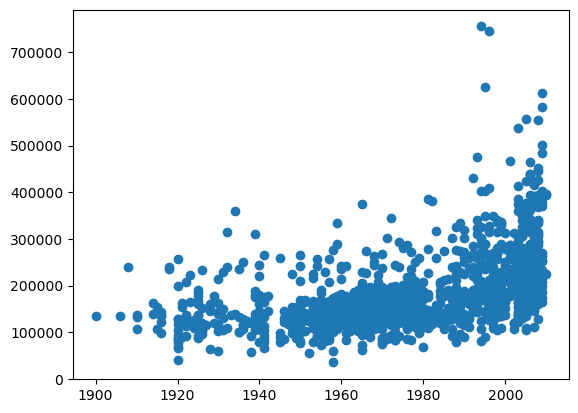

In [53]:
# GarageYrBlt → Garage year built
plt.scatter(x="GarageYrBlt", y="SalePrice", data=train_data)
plt.show()

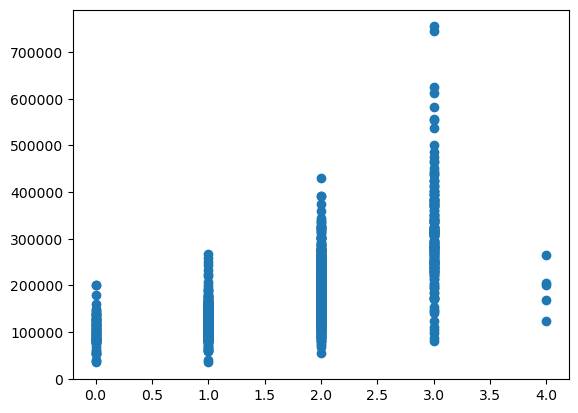

In [54]:
# GarageCars → Garage cars
plt.scatter(x="GarageCars", y="SalePrice", data=train_data)
plt.show()

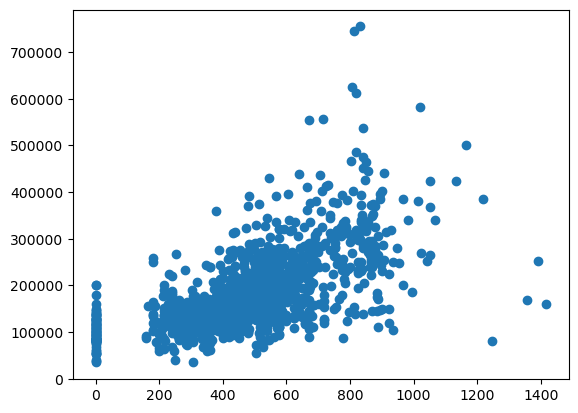

In [55]:
# GarageArea → Garage area
plt.scatter(x="GarageArea", y="SalePrice", data=train_data)
plt.show()

In [56]:
train_data.query("GarageArea > 1200")
# Drop → 48, 185, 249, 297, 313, 335, 378, 440, 457, 523, 581, 597, 635, 691, 706, 738, 769, 809, 825, 934, 954, 1061, 1182, 1190, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
581,20,RL,98.0,12704,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2009,New,Partial,253293
825,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,New,Partial,385000
1061,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000
1190,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


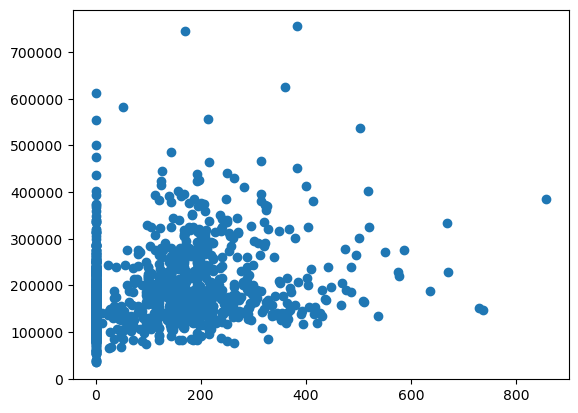

In [57]:
# WoodDeckSF → Wood deck area in square feet
plt.scatter(x="WoodDeckSF", y="SalePrice", data=train_data)
plt.show()

In [58]:
train_data.query("WoodDeckSF > 675")
# Drop → 48, 53, 185, 249, 297, 313, 335, 378, 440, 457, 523, 581, 597, 635, 691, 706, 738, 769, 809, 825, 934, 954, 1061, 1068, 1182, 1190, 1298, 1459

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
53,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,385000
1068,160,RM,42.0,3964,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,151400
1459,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


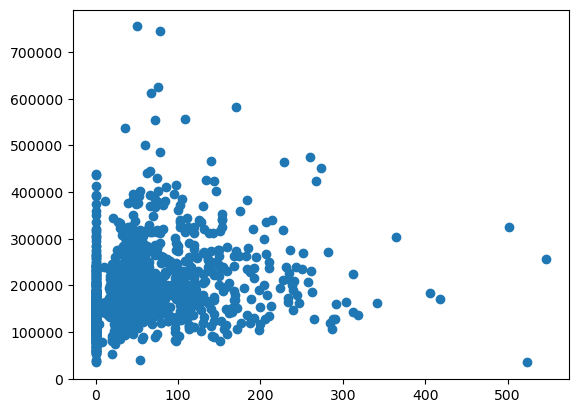

In [59]:
# OpenPorchSF → Open porch area in square feet
plt.scatter(x="OpenPorchSF", y="SalePrice", data=train_data)
plt.show()

In [60]:
train_data.query("OpenPorchSF > 475")
# Drop → 48, 53, 185, 249, 297, 313, 335, 378, 440, 457, 495, 523, 581, 583, 597, 635, 691, 706, 738, 769, 
# 809, 825, 934, 954, 1061, 1068, 1182, 1190, 1298, 1328, 1459

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
495,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
583,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
1328,50,RM,60.0,10440,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,0,NaN,MnPrv,Shed,1150,6,2008,WD,Normal,256000


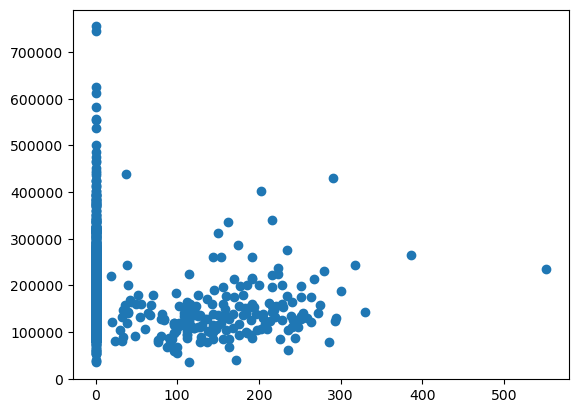

In [61]:
# EnclosedPorch → Enclosed porch area in square feet
plt.scatter(x="EnclosedPorch", y="SalePrice", data=train_data)
plt.show()

In [62]:
train_data.query("EnclosedPorch > 500")
# Drop → 48, 53, 185, 197, 249, 297, 313, 335, 378, 440, 457, 495, 523, 581, 583, 597, 635, 691, 706, 738, 769, 
# 809, 825, 934, 954, 1061, 1068, 1182, 1190, 1298, 1328, 1459

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
197,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,Corner,...,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000


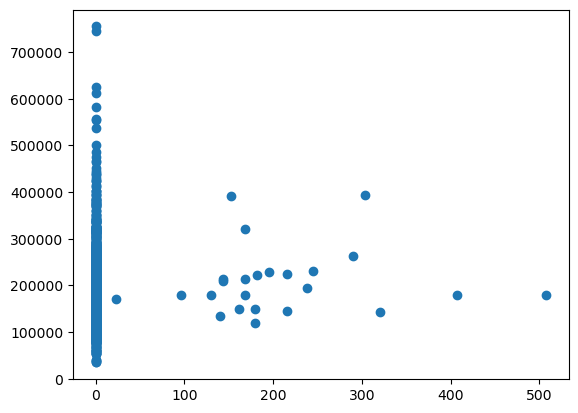

In [63]:
# 3SsnPorch → Three season porch area in square feet
plt.scatter(x="3SsnPorch", y="SalePrice", data=train_data)
plt.show()

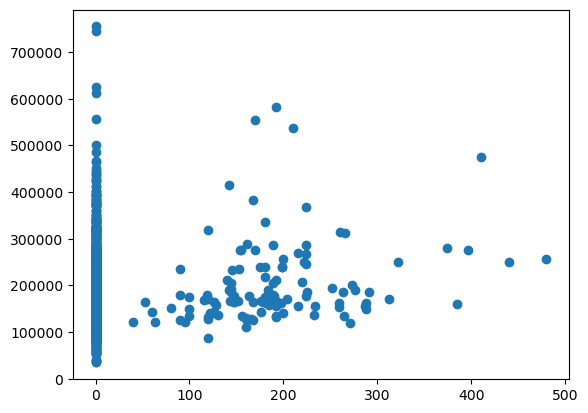

In [64]:
# ScreenPorch → Screen porch area in square feet
plt.scatter(x="ScreenPorch", y="SalePrice", data=train_data)
plt.show()

In [65]:
train_data.query("ScreenPorch > 400")
# Drop → 48, 53, 185, 197, 249, 297, 313, 335, 378, 440, 457, 495, 523, 581, 583, 597, 635, 691, 706, 738, 769, 
# 809, 825, 934, 954, 1061, 1068, 1182, 1190, 1298, 1328, 1386, 1459

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
1328,50,RM,60.0,10440,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,0,NaN,MnPrv,Shed,1150,6,2008,WD,Normal,256000
1386,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,Inside,...,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal,250000


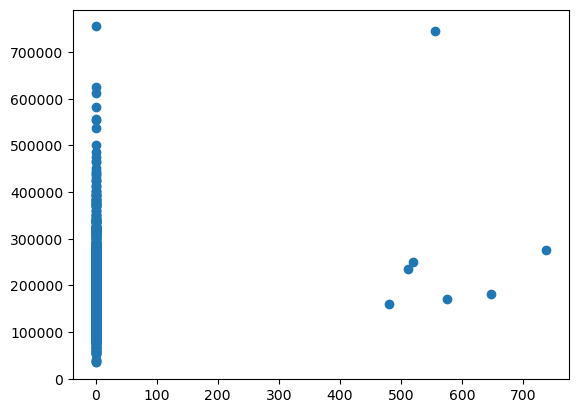

In [66]:
# PoolArea → Pool area in square feet
plt.scatter(x="PoolArea", y="SalePrice", data=train_data)
plt.show()

In [67]:
train_data.query("PoolArea > 700")
# Drop → 48, 53, 185, 197, 249, 297, 313, 335, 378, 440, 457, 495, 523, 581, 583, 597, 635, 691, 706, 738, 769, 
# 809, 825, 934, 954, 1061, 1068, 1182, 1190, 1298, 1328, 1386, 1423, 1459

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1423,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca,274970


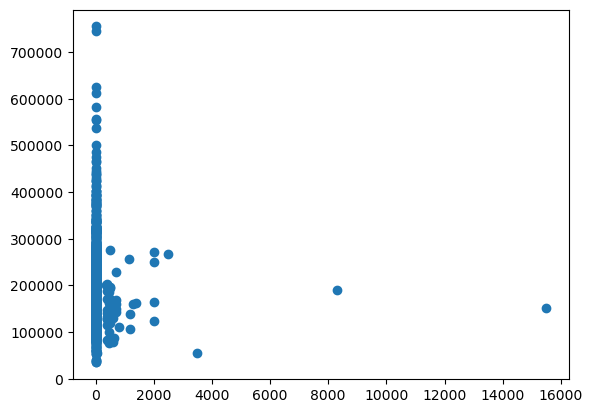

In [68]:
# MiscVal → $Value of miscellaneous feature
plt.scatter(x="MiscVal", y="SalePrice", data=train_data)
plt.show()

In [69]:
train_data.query("MiscVal > 8000")
# Drop → 48, 53, 185, 197, 249, 297, 313, 335, 346, 378, 440, 457, 495, 523, 581, 583, 597, 635, 691, 706, 738, 769, 
# 809, 825, 934, 954, 1061, 1068, 1182, 1190, 1298, 1328, 1230 1386, 1423, 1459

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
346,20,RL,NaN,12772,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,Gar2,15500,4,2007,WD,Normal,151500
1230,90,RL,NaN,18890,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,Gar2,8300,8,2007,WD,Normal,190000


In [70]:
values_indx = [48, 53, 185, 197, 249, 297, 313, 335, 346, 378, 440, 457, 495, 523, 581, 583, 597, 635, 691, 706, 738, 769, 
               809, 825, 934, 954, 1061, 1068, 1182, 1190, 1298, 1328, 1230, 1386, 1423, 1459]

Finally I have found the alleged outliers. 

I am going to proceed to delete them from the dataset.

In [71]:
# DROP THE OUTLIERS
train_data = train_data.drop(values_indx)

My next point is to manage the missing values. Let´s analize them.

In [72]:
pd.DataFrame(train_data.isnull().sum().sort_values(ascending=False)).head(20)

,0
PoolQC,1422
MiscFeature,1377
Alley,1336
Fence,1152
MasVnrType,851
FireplaceQu,681
LotFrontage,251
GarageYrBlt,76
GarageCond,76
GarageType,76


At a glance we can see that there are several columns with more than 1000 missing data. It seems that the most logical thing to do is to delete these columns directly, but let's look at the documentation first.
For example: → **PoolQC: Pool quality**

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	N

At first I thought of deleting this feature, but the logical thing to do is to fill in the missing data with "No Pool" value.

I will study each column one by one to make the best decision: fill the data or delete the feature.o Pool

In [75]:
#PoolQC: Pool quality
#NA	→ No Pool
train_data["PoolQC"].fillna("No Pool", inplace=True)
test_data["PoolQC"].fillna("No Pool", inplace=True)

In [76]:
#MiscFeature: Miscellaneous feature not covered in other categories
#NA  →	None
train_data = train_data.drop("MiscFeature", axis=1)
test_data = test_data.drop("MiscFeature", axis=1)

In [77]:
#Alley: Type of alley access to property
#NA -> No alley access
train_data = train_data.drop("Alley", axis=1)
test_data = test_data.drop("Alley", axis=1)

In [78]:
# Fence: Fence quality
# NA -> No Fence
train_data = train_data.drop("Fence", axis=1)
test_data = test_data.drop("Fence", axis=1)

In [79]:
#MasVnrType: Masonry veneer type
#None -> None
train_data = train_data.drop("MasVnrType", axis=1)
test_data = test_data.drop("MasVnrType", axis=1)

In [80]:
# FireplaceQu: Fireplace quality
# NA -> No Fireplace
train_data["FireplaceQu"].fillna("No Fireplace", inplace=True)
test_data["FireplaceQu"].fillna("No Fireplace", inplace=True)

In [81]:
# LotFrontage: Linear feet of street connected to property
train_data = train_data.drop("LotFrontage", axis=1)
test_data = test_data.drop("LotFrontage", axis=1)

Now we have 76 NAN values for GarageYrBlt, GarageCond, GarageType, GarageFinish,GarageQual. 

For the caterogical columns we can note that the missing values are because there is no garage. I will manage it with np.nan.

In [83]:
#GarageYrBlt: Year garage was built
train_data["GarageYrBlt"].fillna(0, inplace=True)
test_data["GarageYrBlt"].fillna(0, inplace=True)

In [84]:
#GarageCond: Garage condition
# NAN -> No Garage
train_data["GarageCond"].fillna("No Garage", inplace=True)
test_data["GarageCond"].fillna("No Garage", inplace=True)

In [85]:
# GarageType
# NAN -> No Garage
train_data["GarageType"].fillna("No Garage", inplace=True)
test_data["GarageType"].fillna("No Garage", inplace=True)

In [86]:
#GarageFinish: Interior finish of the garage
# NAN -> No Garage
train_data["GarageFinish"].fillna("No Garage", inplace=True)
test_data["GarageFinish"].fillna("No Garage", inplace=True)

In [87]:
#GarageQual: Garage quality
# NAN -> No Garage
train_data["GarageQual"].fillna("No Garage", inplace=True)
test_data["GarageQual"].fillna("No Garage", inplace=True)

I will do the same managing with BsmtExposure, BsmtFinType2, BsmtCond, BsmtQual, BsmtFinType1.

In [88]:
# BsmtExposure: Refers to walkout or garden level walls
# NA	No Basement
train_data["BsmtExposure"].fillna("No Basement", inplace=True)
test_data["BsmtExposure"].fillna("No Basement", inplace=True)

In [89]:
# BsmtFinType2: Rating of basement finished area (if multiple types)
# NA	No Basement
train_data["BsmtFinType2"].fillna("No Basement", inplace=True)
test_data["BsmtFinType2"].fillna("No Basement", inplace=True)

In [90]:
# BsmtCond: Evaluates the general condition of the basement
# NA	No Basement
train_data["BsmtCond"].fillna("No Basement", inplace=True)
test_data["BsmtCond"].fillna("No Basement", inplace=True)

In [91]:
# BsmtQual: Evaluates the height of the basement
# NA	No Basement
train_data["BsmtQual"].fillna("No Basement", inplace=True)
test_data["BsmtQual"].fillna("No Basement", inplace=True)

In [92]:
# BsmtFinType1: Rating of basement finished area
#    NA	No Basement
train_data["BsmtFinType1"].fillna("No Basement", inplace=True)
test_data["BsmtFinType1"].fillna("No Basement", inplace=True)

In [93]:
#MasVnrArea: Masonry veneer area in square feet
train_data["MasVnrArea"].fillna(train_data["MasVnrArea"].median(), inplace=True)
test_data["MasVnrArea"].fillna(train_data["MasVnrArea"].median(), inplace=True)

In [94]:
#Electrical: Electrical system
train_data["Electrical"].fillna(train_data["Electrical"].mode()[0], inplace=True)
test_data["Electrical"].fillna(train_data["Electrical"].mode()[0], inplace=True)

Now we have managed all the missing data from train_data. Let´s take a look if there is any missing values in the test dataset.
Let us see.

In [96]:
pd.DataFrame(test_data.isnull().sum().sort_values(ascending=False)).head(20)

,0
MSZoning,4
BsmtFullBath,2
BsmtHalfBath,2
Utilities,2
Functional,2
Exterior1st,1
BsmtFinSF1,1
Exterior2nd,1
GarageCars,1
GarageArea,1


In [97]:
# MSZoning: Identifies the general zoning classification of the sale.
test_data["MSZoning"].fillna(train_data["MSZoning"].mode()[0], inplace=True)

#BsmtFullBath: Basement full bathrooms
test_data["BsmtFullBath"].fillna(train_data["BsmtFullBath"].mode()[0], inplace=True)

#BsmtHalfBath: Basement half bathrooms
test_data["BsmtHalfBath"].fillna(train_data["BsmtHalfBath"].mode()[0], inplace=True)

# Utilities: Type of utilities available
test_data["Utilities"].fillna(train_data["Utilities"].mode()[0], inplace=True)

# Functional: Home functionality (Assume typical unless deductions are warranted)
test_data["Functional"].fillna(train_data["Functional"].mode()[0], inplace=True)

# Exterior1st: Exterior covering on house
test_data["Exterior1st"].fillna(train_data["Exterior1st"].mode()[0], inplace=True)

# BsmtFinSF1: Type 1 finished square feet
test_data["BsmtFinSF1"].fillna(train_data["BsmtFinSF1"].median(), inplace=True)

# Exterior2nd: Exterior covering on house (if more than one material)
test_data["Exterior2nd"].fillna("Other", inplace=True)

# GarageCars: Size of garage in car capacity
test_data["GarageCars"].fillna(test_data["GarageCars"].mode()[0], inplace=True)

# GarageArea: Size of garage in square feet
test_data["GarageArea"].fillna(test_data["GarageArea"].median(), inplace=True)

#KitchenQual: Kitchen quality
test_data["KitchenQual"].fillna(test_data["KitchenQual"].mode()[0], inplace=True)

#BsmtFinSF2: Type 2 finished square feet
test_data["BsmtFinSF2"].fillna(test_data["BsmtFinSF2"].median(), inplace=True)

#BsmtUnfSF: Unfinished square feet of basement area
test_data["BsmtUnfSF"].fillna(test_data["BsmtUnfSF"].median(), inplace=True)

#TotalBsmtSF: Total square feet of basement area
test_data["TotalBsmtSF"].fillna(test_data["TotalBsmtSF"].median(), inplace=True)

#SaleType: Type of sale
test_data["SaleType"].fillna("Other", inplace=True)

## FEATURE ENGINEERING

In [99]:
#Create a new feature House Age
train_data["house_age"] = train_data["YrSold"] - train_data["YearBuilt"]
test_data["house_age"] = test_data["YrSold"] - test_data["YearBuilt"]

In [100]:
#Create a new feature House Remodell Age
train_data["house_remodel_age"] = train_data["YrSold"] - train_data["YearRemodAdd"]
test_data["house_remodel_age"] = test_data["YrSold"] - test_data["YearRemodAdd"]

In [101]:
# Create a new feature Total Square Feet
train_data["total_sq_ft"] = train_data["1stFlrSF"] + train_data["2ndFlrSF"] + train_data["BsmtFinSF1"] + train_data["BsmtFinSF2"]
test_data["total_sq_ft"] = test_data["1stFlrSF"] + test_data["2ndFlrSF"] + test_data["BsmtFinSF1"] + test_data["BsmtFinSF2"]

In [102]:
# Create a new feature Total Area
train_data["total_area"] = train_data["GrLivArea"] + train_data["TotalBsmtSF"]
test_data["total_area"] = test_data["GrLivArea"] + test_data["TotalBsmtSF"]

In [103]:
# Create a new feature Total Baths
train_data["total_baths"] = train_data["BsmtFullBath"] + train_data["FullBath"] + 0.5*train_data["HalfBath"]
test_data["total_baths"] = test_data["BsmtFullBath"] + test_data["FullBath"] + 0.5*test_data["HalfBath"]

In [104]:
# Create a new feature Total Porch
train_data["total_porch"] = train_data["OpenPorchSF"] + train_data["EnclosedPorch"] + train_data["3SsnPorch"] + train_data["ScreenPorch"]
test_data["total_porch"] = test_data["OpenPorchSF"] + test_data["EnclosedPorch"] + test_data["3SsnPorch"] + test_data["ScreenPorch"]

In [106]:
# DROP DATA 
train_data = train_data.drop(columns=["YrSold", "YearBuilt", "YearRemodAdd", "1stFlrSF", "2ndFlrSF", "BsmtFinSF1", "BsmtFinSF2", 
                         "GrLivArea", "TotalBsmtSF", "BsmtFullBath", "FullBath", "HalfBath", 
                         "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"])

test_data = test_data.drop(columns=["YrSold", "YearBuilt", "YearRemodAdd", "1stFlrSF", "2ndFlrSF", "BsmtFinSF1", "BsmtFinSF2", 
                         "GrLivArea", "TotalBsmtSF", "BsmtFullBath", "FullBath", "HalfBath", 
                         "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"])

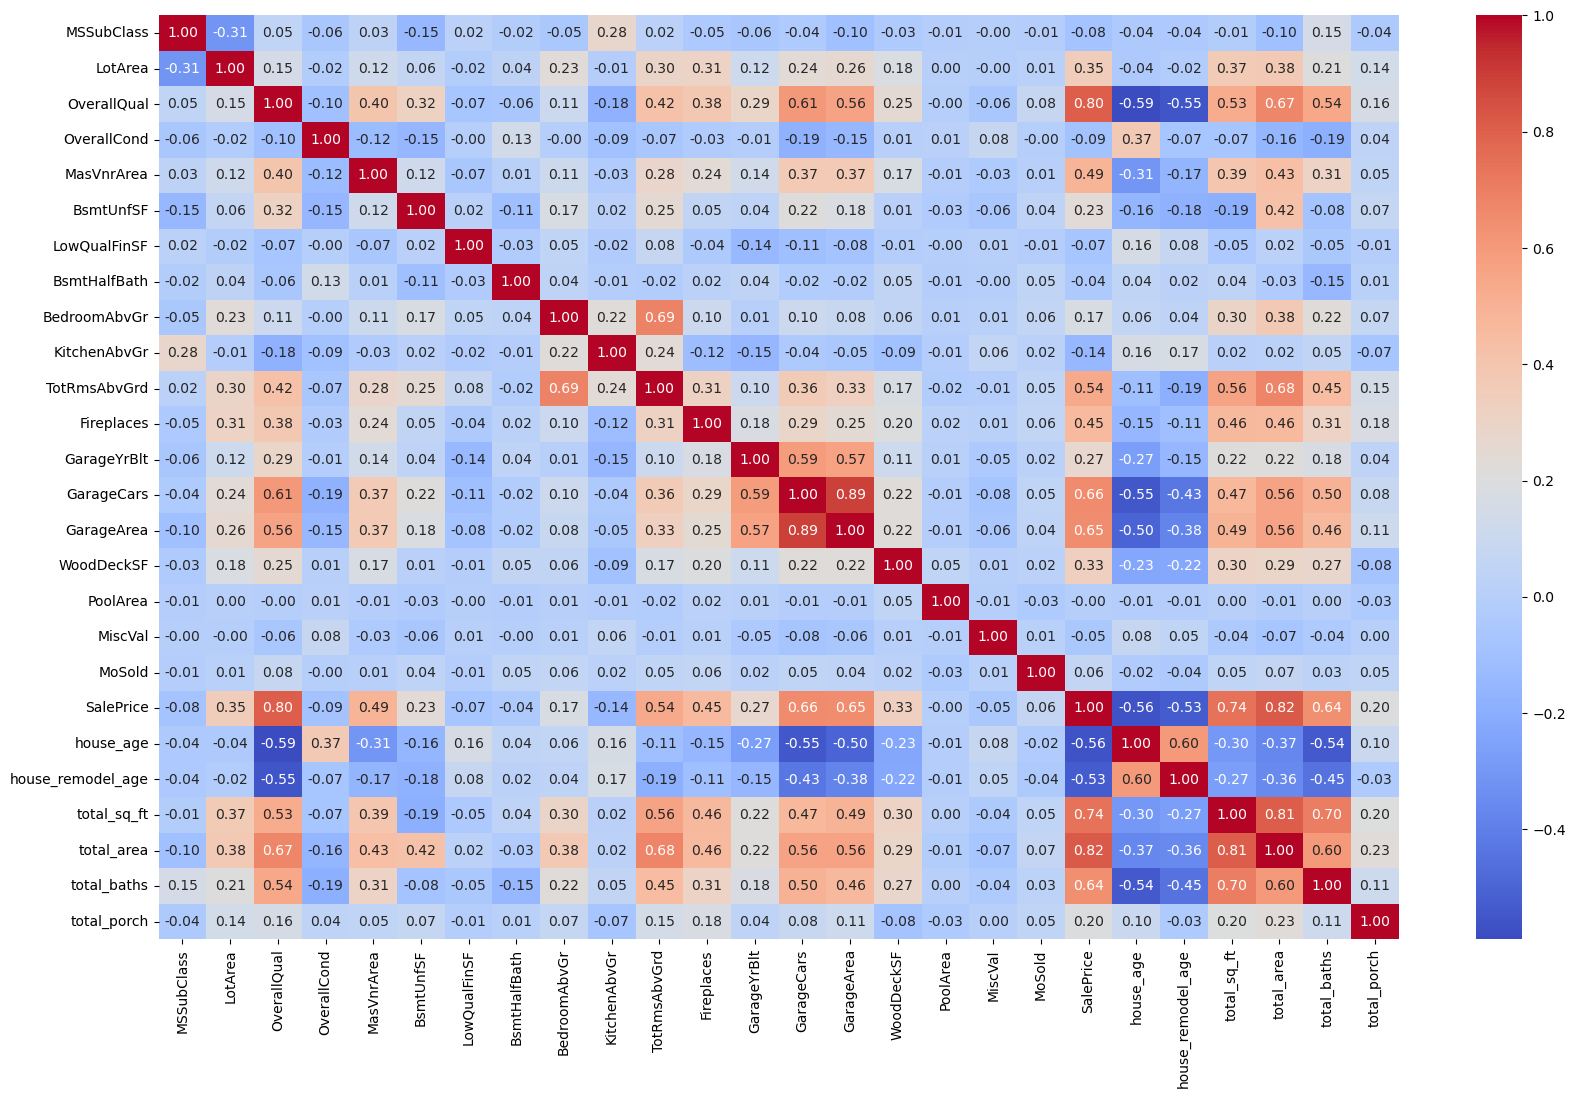

In [108]:
correlation_matix = train_data.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [109]:
# Garage Area and Garage Cars are highly correlated
train_data.drop("GarageArea", axis=1, inplace=True)
test_data.drop("GarageArea", axis=1, inplace=True)

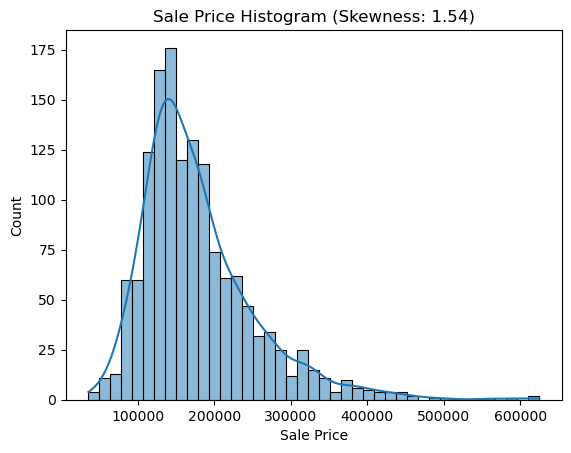

In [110]:
ax = sns.histplot(
    train_data,
    x=train_data["SalePrice"],
    kde=True
)
skewness = skew(train_data["SalePrice"])
ax.set_title(f'Sale Price Histogram (Skewness: {skewness:.2f})')
ax.set_xlabel('Sale Price')
plt.show()

The histogram has a positive skewness. For better performing of the algorithms, I am performing a logarithmic transformation of the variables to obtain a symmetric distribution (closer to normal), so we can use the linear regression model. The transformation performed is:

$$log1p = log(1+x)$$


Remember to perform the inverse transformation to obtain the original value:


$$expm1 = exp(x) - 1$$





In [111]:
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

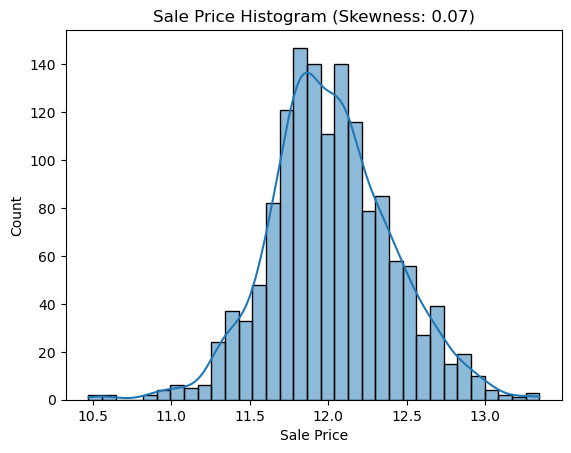

In [113]:
ax = sns.histplot(
    train_data,
    x=train_data["SalePrice"],
    kde=True
)
skewness = skew(train_data["SalePrice"])
ax.set_title(f'Sale Price Histogram (Skewness: {skewness:.2f})')
ax.set_xlabel('Sale Price')
plt.show()

## Encoding the categorical data
In this part I will separate the columns that are categorical. 

Then I will divide them in 2 groups ordinal or not.

Finally I will proceed to encode them.

In [114]:
train_data.dtypes[train_data.dtypes == "object"].index.tolist()

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'SaleType',
 'SaleCondition']

In [115]:
# ordinal data
ode = ["LotShape", "LandContour", "Utilities", "LandSlope", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtFinType1", "BsmtFinType2", 
       "HeatingQC", "CentralAir", "KitchenQual", "Functional", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PoolQC"]

In [116]:
# categorical data
ohe = ["MSZoning", "Street", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st",
      "Exterior2nd", "Foundation", "BsmtExposure", "Heating", "Electrical", "GarageType", "PavedDrive", "SaleType", "SaleCondition"]

In [117]:
num_cols = train_data.select_dtypes(include=["float64", "int64"]).columns
num_cols = num_cols.drop("SalePrice")

## Pipeline

In [119]:
num_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [120]:
ode_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

In [121]:
ohe_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [122]:
column_tranformation = ColumnTransformer(transformers=[
    ("num_pipe", num_pipeline, num_cols),
    ("ode_pipe", ode_pipeline, ode),
    ("ohe_pipe", ohe_pipeline, ohe)],
    remainder="passthrough",
    n_jobs=-1
)

In [123]:
pipeline = Pipeline(steps=[
    ("preprocessing", column_tranformation)
])

## Set up X and y

In [125]:
X = train_data.drop("SalePrice", axis=1)
y = train_data["SalePrice"]

In [127]:
x_preprocessed = pipeline.fit_transform(X)

# Also prepare test_data for predicting
test_data_preprocessed = pipeline.fit_transform(test_data)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(x_preprocessed, y, test_size= 0.2, random_state=42)

## Models

### Linear Regression

In [133]:
lr = LinearRegression()

In [134]:
# train the model
lr.fit(X_train, y_train)

LinearRegression()

In [135]:
pred_lr = lr.predict(X_test)

In [136]:
mean_squared_error(y_test, pred_lr, squared=False)

978461935.3941786

The result is really bad. It was expected, since Linear Regression is based on discover the best-fit line for a set of data.

So I won´t use this model for my prediction.

### Random Forest Regressor

In [137]:
rfr = RandomForestRegressor(random_state=42)

In [138]:
#train the model
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [139]:
pred_rfr = rfr.predict(X_test)

In [140]:
mean_squared_error(y_test, pred_rfr, squared=False)

0.1344016978538623

Compared to the Linear Regression method, Random Forest could be great solution. Anyways I will try to tunning it a little bit more.

In [141]:
# Hyperparameters
param_grid_rfr = {
    "max_depth": [5, 10, 15],
    "n_estimators": [50, 100, 250],
    "min_samples_split": [3, 5, 10],
}

In [142]:
rfr_cv = GridSearchCV(rfr, param_grid_rfr, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

In [143]:
rfr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [50, 100, 250]},
             scoring='neg_mean_squared_error')

In [144]:
np.sqrt(-1 * rfr_cv.best_score_)

0.13391675275125364

In [145]:
rfr_cv.best_params_

{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 250}

In [146]:
# OPTIMIZED RandomForestRegressor
rfr_optimized = RandomForestRegressor(
    min_samples_split = 3,
    max_depth = 15,
    n_estimators = 250,
    criterion= 'squared_error')

In [147]:
rfr_optimized.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_split=3, n_estimators=250)

In [148]:
prediction_dtr_optimized = rfr_optimized.predict(X_test)

In [149]:
mean_squared_error(y_test, prediction_dtr_optimized, squared=False)

0.1317256144352214

### XGB Regressor

In [150]:
xgb = XGBRegressor(random_state=42)

In [151]:
param_grid_xgb = {
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators": [50, 100, 250],
    "max_depth": [3, 5, 10],
    "min_child_weight": [1, 2, 3],
    "gamma": [0, 0.1, 0.2],
    "subsample": [0.8, 0.9, 1],
    "colsample_bytree": [0.8, 0.9, 1]
}

In [152]:
xgb_cv = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

In [ ]:
xgb_cv.fit(X_train, y_train)

In [ ]:
pred_xgb = xgb_cv.predict(X_test)

In [ ]:
mean_squared_error(y_test, pred_xgb, squared=False)

### Ridge regression

In [ ]:
ridge = Ridge()

In [ ]:
param_grid_ridge = {
    "alpha": [0.05, 0.1, 1, 3, 5, 10],
    "solver": ["auto", "svd", "cholesky", "lsqr", "sag", "sparse_cg"],
}

In [ ]:
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

In [ ]:
ridge_cv.fit(X_train, y_train)

In [ ]:
pred_ridge = ridge_cv.predict(X_test)

In [ ]:
np.sqrt(-1 * ridge_cv.best_score_)

In [ ]:
mean_squared_error(y_test, pred_ridge, squared=False)

### Gradient Boosting Regressor

In [ ]:
gbr = GradientBoostingRegressor(random_state=42)

In [ ]:
param_grid_gbr = {
    "min_samples_leaf": [1, 10, 25, 50],
    "max_depth": [5, 10, 15],
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.001, 0.001, 0.1]}

In [ ]:
gbr_cv = GridSearchCV(gbr, param_grid_gbr, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

In [ ]:
gbr_cv.fit(X_train, y_train)

In [ ]:
pred_gbr = gbr_cv.predict(X_test)

In [ ]:
np.sqrt(-1 * gbr_cv.best_score_)

In [ ]:
mean_squared_error(y_test, pred_ridge, squared=False)

### LightGBMRegressor

In [ ]:
lgbm = lgb.LGBMRegressor()

In [ ]:
param_grid_lgbm = {
    "boosting_type": ["gbdt", "dart"],
    "num_leaves": [10, 20, 30, 40],
    "learning_rate": [0.001, 0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 200]
}

In [ ]:
lgbm_cv = GridSearchCV(lgbm, param_grid_lgbm, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

In [ ]:
lgbm_cv.fit(X_train, y_train)

In [ ]:
pred_lgbm = lgbm_cv.predict(X_test)

In [ ]:
mean_squared_error(y_test, pred_ridge, squared=False)

### CatBoostRegressor

In [ ]:
catbr = CatBoostRegressor(loss_function="RMSE", verbose=False)

In [ ]:
param_grid_catbr = {
    "iterations": [20, 50, 100, 200],
    "depth": [1, 3, 5, 8],
    "learning_rate": [0.001, 0.01, 0.05, 0.1]
}

In [ ]:
catbr_cv = GridSearchCV(catbr, param_grid_catbr, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

In [ ]:
catbr_cv.fit(X_train, y_train)

In [ ]:
pred_catbr = catbr_cv.predict(X_test)

In [ ]:
np.sqrt(-1 * catbr_cv.best_score_)

In [ ]:
mean_squared_error(y_test, pred_catbr, squared=False)

### Voting Regressor

In [ ]:
voting_regressor = VotingRegressor([
    ("gbr", gbr_cv.best_estimator_),
    ("xgb", xgb_cv.best_estimator_),
    ("ridge", ridge_cv.best_estimator_)],
    weights=[3, 2, 1]
)

In [ ]:
voting_regressor.fit(X_train, y_train)

In [ ]:
pred_voting_regressor = voting_regressor.predict(X_test)

In [ ]:
mean_squared_error(y_test, pred_voting_regressor, squared=False)

### StackingRegressor

In [ ]:
estimators = [
    ('gbr', gbr_cv.best_estimator_),
    ('xgb', xgb_cv.best_estimator_),
    ('catbr', catbr_cv.best_estimator_),
    ('lgbm', lgbm_cv.best_estimator_),
    ('rfr_optimized', rfr_optimized)
]

In [ ]:
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=voting_regressor,
    verbose=False
)

In [ ]:
stacking_regressor.fit(X_train, y_train)

In [ ]:
pred_stacking_regressor = stacking_regressor.predict(X_test)

In [ ]:
mean_squared_error(y_test, pred_stacking_regressor, squared=False)

## Predicting and submitting solutions